# Pareto NBD (Negative Binomial Distribution) model for customer life-time value

* This model will use historical transaction data to predict how valuable is a customer is in the future.
* CLV: Customer lifetime value refers to the total value a customer had for the company (profit generated by the customer).
* Pareto NBD can be extended to included more realtime features (covariates).

this model is inspired by Jean-René Gauthier's tutorial https://www.oreilly.com/pub/e/3861. A few images and bits of text where also copied from their.

<img src="../img/customer_journey.png" />

Distribution for Lifetime of cutomer is exponential:
\begin{aligned}
p(x;\mu) = \begin{cases}
\mu e^{-\mu t} & t \ge 0, \\
0 & x < 0.
\end{cases}
where \ t \ is \ the \ time \ since \ last \ purchase.
\end{aligned}

Distribution of purchases is Poisson:

\begin{aligned}
P(k{\text{ purchases in interval}})=e^{-\lambda }{\frac {\lambda ^{k}}{k!}}
\end{aligned}

Probability of purchasing at least 1 item at time t:

\begin{aligned}
P(k >= 1 \text{at time t since last purchase})=e^{-\mu*t }\{1 - e^{-\lambda}\}
\end{aligned}

# Read Transactions

In [161]:
import pandas as pd

In [162]:
tr = pd.read_csv("../data/transactions.csv", parse_dates=["date"])

In [163]:
tr.head()

,cust,date,sales
0,4,1997-01-18,29.73
1,4,1997-08-02,14.96
2,4,1997-12-12,26.48
3,18,1997-01-04,14.96
4,21,1997-01-01,63.34


# Compute the RFM Dataframe

<strong>It can be shown that the Pareto NBD model can be converted to a simpler model which requires the RFM DataFrame only, which is a memoriless version of the transactions from the point of view of the timestamp we are looking from.</strong>

In this section, we will generate the recency-frequency-monetary value (RFM) object.
    * Recency : time between first and last transaction
    * Frequency : here frequency really refers to repeat frequency, i.e. the number of purchases beyond the initial one. i.e. repeat frequency = purchase counts - 1 )
    * monetary value : mean of all the transactions in the training periods
    * T : time between first purchase and end of calibration period

In [164]:
def compute_rfm(x, timestamp): 
    x['recency'] = (x['date'].max() - x['date'].min()).days
    x['frequency'] = x['date'].count()-1
    x['T'] = (timestamp - x['date'].min()).days
    x['monetary_value'] = x['sales'].mean()
    return x[0:1]

In [165]:
train = tr[tr.date <= pd.to_datetime('1997-12-31')]
train = train.groupby("cust").apply(compute_rfm, pd.to_datetime('1997-12-31')) \
                             .reset_index(drop=True)

# Model

In [166]:
import pystan

In [51]:
paretonbd_model="""
data{
    int<lower=1> n_cust;         # Number of customers 
    vector<lower=0>[n_cust] x;   # Frequency of purchases
    vector<lower=0>[n_cust] tx;  # Recency of purchases
    vector<lower=0>[n_cust] T;   # Time since last purchase
}

parameters{
    vector<lower=0,upper=1.0>[n_cust] la; # Purchase rate
    vector<lower=0,upper=1.0>[n_cust] mu; # Lifetime
}

model{
    # temporary variables
    vector[n_cust] like1; # likelihood
    vector[n_cust] like2; # likelihood

    # Priors for lambda and mu
    la ~ gamma(1, 10); 
    mu ~ gamma(1, 10);

    # The likelihood of the Pareto/NBD model
    like1 = x       .* log(la) + log(mu) - log(mu+la) - tx .* (mu+la);
    like2 = (x + 1) .* log(la) -           log(mu+la) - T  .* (la+mu);

    # Here we increment the log probability density (target) accordingly
    increment_log_prob(log(exp(like1) + exp(like2)));
}
"""

In [ ]:
model = pystan.StanModel(model_code=paretonbd_model)

In [172]:
samples = model.sampling(data={
    'n_cust': len(train),
    'x':      train['frequency'].values.tolist(),
    'tx':     train['recency'].values.tolist(),
    'T':      train['T'].values.tolist(),
}, warmup=500, iter=1000, chains=4)

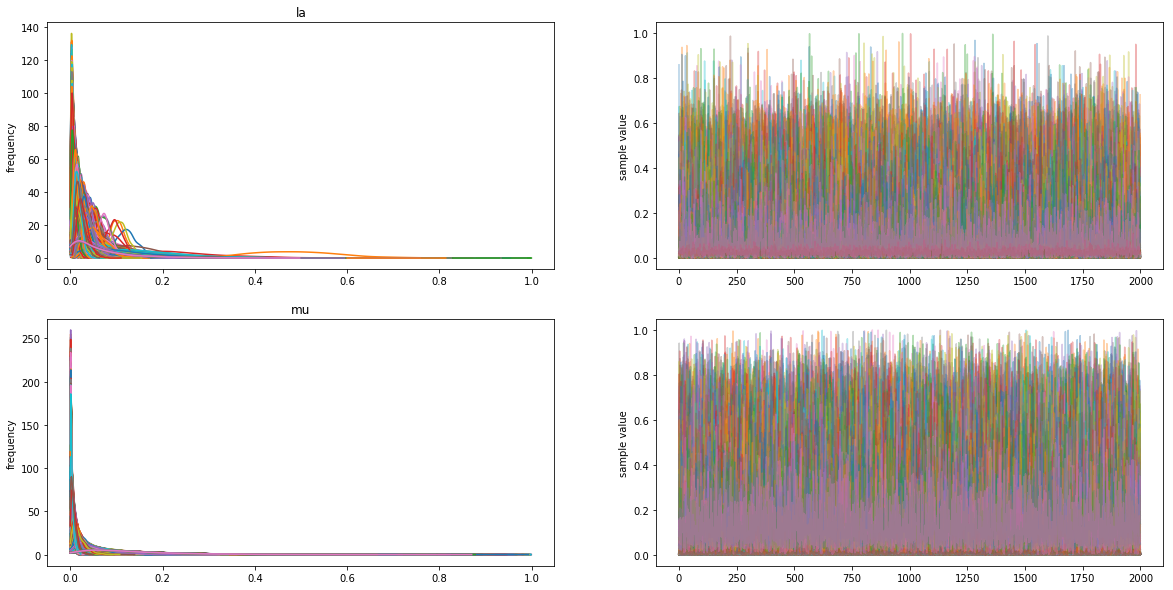

In [173]:
ax = samples.plot()
ax.set_size_inches(20, 10)

# Predicting the Future

* There is a closed form for predicting the future after having lambda and mu. But these can also be integrated in the model.
* The model is weak, it needs improving.

# Improving Pareto NBD

* Including Monetary Value.
* Partial pooling: Grouping the similar customers together.
* Hyper Priors: Adding priors to priors.
* group-level predictors: Use a regression model using other customer and time features to predict lambda and mu. 

# Classical Model

* The following is the raw Pareto NBD model without the RFM Matrix.



<img src="../img/pareto_nbd.png" />

In [ ]:
import pystan

In [61]:
paretonbd_model="""
data {
    int N;         # Number of customers
    int T;         # Number of days
    int tlog[T,N]; # Transaction log
}
parameters {
    vector<lower=0,upper=1.0>[N] la; # Purchase rate
    vector<lower=0,upper=1.0>[N] mu; # Lifetime
    
    # This wont run in Stan. Descrete sampling.
    # int flog[20,N]; # Future transaction log.
}
model {
    # Temp variables
    int last[N];    # Time of last pruchase per customer
    int Tlast;      # Time of since last purchase
    vector[2] prob; 
    
    # Priors for lambda and mu
    la ~ gamma(0.5, 10); 
    mu ~ gamma(0.5, 10);
    
    for (n in 1:N) {
        last[n] = -1;
    }
    
    # Main model
    for (n in 1:N) {
        for (t in 1:T) {
            if (last[n] != -1) {
                Tlast = t - last[n];
                prob[2] = exp(-mu[n] * Tlast) * (1 - exp(-la[n]));
                prob[1] = 1 - prob[2];
                tlog[t,n] ~ categorical(prob);
            }
            if (tlog[t,n] == 2) {
                last[n] = t;
            }
        }
        
       # This wont run in Stan. Descrete sampling.
       # for (t in T+1:T+20) {
       #     prob[2] = exp(-mu[n] * Tlast) * (1 - exp(-la[n]));
       #     prob[1] = 1 - prob[2];
       #     flog[t,n] ~ categorical(prob);
       #     if (flog[t,n] == 2) {
       #         last[n] = t;
       #     }
       # }
    }
}
"""

# Compile Model

In [62]:
model = pystan.StanModel(model_code=paretonbd_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4ab567da296192e433339369ec08b44f NOW.


# Generate Data

In [63]:
import pandas as pd
data = pd.DataFrame({
    "cust1": [0,1,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0],
    "cust2": [0,1,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
    "cust3": [1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0],
    "cust4": [1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0],
    "cust5": [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0],
}) + 1

# Sample

In [64]:
samples = model.sampling(data={
    "N": data.shape[1],
    "T": data.shape[0],
    "tlog": data.values
})

In [65]:
samples

Inference for Stan model: anon_model_4ab567da296192e433339369ec08b44f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
la[1]   0.37  2.0e-3   0.12   0.17   0.28   0.36   0.44   0.65   3668    1.0
la[2]   0.21  1.6e-3   0.09   0.07   0.14   0.19   0.26   0.42   3530    1.0
la[3]   0.08  8.0e-4   0.06   0.01   0.04   0.07   0.11   0.22   4826    1.0
la[4]   0.12  1.1e-3   0.07   0.02   0.07   0.11   0.15   0.28   3632    1.0
la[5]   0.12  9.5e-4   0.06   0.03   0.07   0.11   0.16   0.28   4666    1.0
mu[1]   0.03  5.8e-4   0.04 1.9e-5 3.1e-3   0.01   0.04   0.14   4598    1.0
mu[2]   0.04  7.9e-4   0.05 2.5e-5 4.5e-3   0.02   0.06   0.18   4085    1.0
mu[3]   0.02  4.7e-4   0.03 2.3e-5 2.4e-3   0.01   0.03   0.12   5041    1.0
mu[4]   0.02  4.4e-4   0.03 3.9e-5 2.6e-3   0.01   0.03   0.11   4645    1.0
mu[5]   0.02  4.6e-4   0.03 2.9e-5 2.7e-3

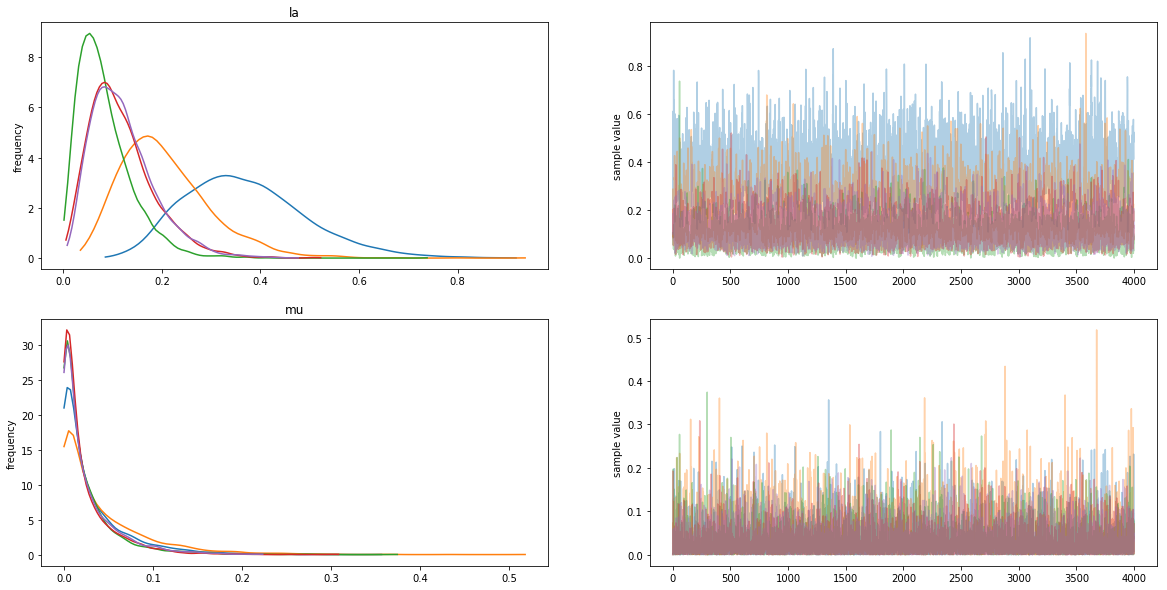

In [66]:
ax = samples.plot()
ax.set_size_inches(20, 10)